# Projet final: Diagnostic de COVID-19 (partie 2: Pré-traitement des données)

URL:

- dataset: https://www.kaggle.com/datasets/einsteindata4u/covid19
- tutoriel: https://youtu.be/x8yu8sq8mdw?si=tpWofNocIIun90qv

**En général:**

- **Définition:**

Le preprocessing est l'étape qui consiste à préparer les données avant de les fournir à la machine pour son apprentissage.

- **Les objectifs:**

  - Mettre les données dans un format propice au ML.
  - (Avoir un dataset le plus propre possible pour) Améliorer la performance du modèle.

- **Les techniques utilisées:**

  - Encodage
  - Normalisation
  - Nettoyage NaN
  - Feature Selection
  - Feature Extraction
  - Nettoyage Outliers
  - Création de nouvelles variables
    Bref, il existe beaucoup d'opérations possibles.

**Dans ce projet:**

- **Objectifs:**
  1. **Mettre les données dans un format propice au ML:**
       - Train/Test
       - Encodage
       - Nettoyage des NaNs
  2. **Créer un 1er modèle:**
       - Evaluer le modèle
       - Faire le diagnostic du modèle
  3. **Améliorer la performance du modèle:**
       - Feature Selection
       - Feature Engineering
       - Feature Scaling
       - Suppression des Outliers
     
**Explication:**
1) **Mettre les données dans un format propice au ML:** Train/Test + Encodage + Dropna
2) **Développer un 1er modèle extrêmement basique, exp: Decision Tree:**
   - **Learning curves:**
     - **Underfitting =>** Polynomial Features, Feature Engineering => Modèle plus complexe
     - **Overfitting =>** Imputation/Fillna, SelectFromModel => Régularisation (réduire marginalement la précision de l'entraînement pour augmenter la généralisabilité)

A partir de là, on est dans une **boucle itérative** dans laquelle on part d'une idée, on l'implémente et on l'évalue:

**idée => code => évaluation => idée => code => évaluation =>...etc**

En applicant cela, on obtient un code assez robuste de preprocessing.

# Pré-traitement des données (Preprocessing)

In [5]:
#importations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#traintest
from sklearn.model_selection import train_test_split

#modélisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

#procédure d'évaluation
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [6]:
#configuration de l'affichage de Pandas pour montrer jusqu'à 111 lignes
#si df a plus de 111 lignes, il sera tronqué, et seules les lignes requises ou une indication d'éléments supplémentaires seront affichées
pd.set_option('display.max_row', 111)

#configuration de l'affichage de Pandas pour montrer jusqu'à 111 colonnes  
#si df a plus de 111 colonnes, il sera tronqué, et seules les colonnes requises ou une indication d'éléments supplémentaires seront affichées
pd.set_option('display.max_column', 111)

## Préparation des données pour le preprocessing

In [8]:
#définir data
data = pd.read_excel('dataset.xlsx')

#afficher les 5 premières lignes de data
data.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
#créer une copie du dataset
#définir df
df = data.copy()

In [10]:
'''
En général, on donne un autre nom à ce nouveau df (exp: df1),
comme ça, le df qui a servit à l'EDA reste disponible pour observer certaines choses dessus
Dans ce cas, on le nomme df pour simplifier les choses
'''

"\nEn général, on donne un autre nom à ce nouveau df (exp: df1),\ncomme ça, le df qui a servit à l'EDA reste disponible pour observer certaines choses dessus\nDans ce cas, on le nomme df pour simplifier les choses\n"

In [11]:
#afficher les 5 premières lignes de df pour vérifier
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [12]:
#la forme de df
df.shape

(5644, 111)

In [13]:
'''
On a encore une fois, le df du tout début du travail, donc beaucoup de colonnes inutiles,
on sélectionne alors les colonnes qu'on a put identifier, dans l'EDA, comme utiles
'''

"\nOn a encore une fois, le df du tout début du travail, donc beaucoup de colonnes inutiles,\non sélectionne alors les colonnes qu'on a put identifier, dans l'EDA, comme utiles\n"

In [14]:
#afficher le % des valeurs maquantes dans chaque colonne de df

#df.isna().sum(): la somme des valeurs maquantes dans chaque colonne
#df.shape[0]: représente le nombre de lignes dans df
#(df.isna().sum()/df.shape[0]): la proportion (donc le %) des valeurs maquantes dans chaque colonne de df
#sort_values(): ordonne les valeurs
#ascending=True: trie le taux des valeurs manquantes par ordre croissant
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Patient ID                                               0.000000
Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydoph

In [15]:
#enregistrer sous la variable appelée missing_rate
missing_rate = (df.isna().sum()/df.shape[0]).sort_values(ascending=True)

In [16]:
#on sélectionne les colonnes du DataFrame 'df' qui contiennent moins de 90% de valeurs manquantes

#df.isna(): génère un DataFrame où chaque valeur est remplacée par True (si elle est manquante) ou False (si elle n'est pas manquante)
#df.sum(): calcule la somme des True pour chaque colonne, True équivaut à 1 et False à 0, cela donne le nombre total de valeurs manquantes dans chaque colonne
#df.shape[0]: donne le nombre total de lignes dans le DataFrame
#(df.isna().sum()/df.shape[0]): la proportion de valeurs manquantes par colonne
#df.columns[...]:renvoie l'index des colonnes du DataFrame df. C'est une liste de noms de colonnes
#df[df.columns[...] < 0.9]: sélectionne les colonnes du DataFrame 'df' qui contiennent moins de 90% de valeurs manquantes
#définir df
df = df[df.columns[df.isna().sum() / df.shape[0] < 0.9]]

#afficher les colonnes de df pour vérifier le résultat  
df.columns

Index(['Patient ID', 'Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
       'Lymphocytes', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)',
       'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'In

In [17]:
#éliminer la colonne Patient ID qui est inutile
#axis=1: signifie l'axe des colonnes
#définir df
df = df.drop('Patient ID', axis=1)

#afficher les colonnes de df
df.columns

Index(['Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
       'Lymphocytes', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)',
       'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Influenza B, rap

In [18]:
#définir la nouvelle valeur de missing_rate
missing_rate = (df.isna().sum()/df.shape[0]).sort_values(ascending=True)

#afficher missing_rate
missing_rate

Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Influenza B                                              0.760099
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Metapneumovirus                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydophila pneumoniae                                 0.760454
Parainfluenza 3                                          0.760454
Coronaviru

In [19]:
#définir blood_columns et viral_columns
blood_columns = []    #liste vide
viral_columns = []    #liste vide

#la boucle for pour classer les variables (colonnes)

#parcourir chaque colonne dans l'index de 'missing_rate' 
for col in missing_rate.index:  
    #vérifier si le taux de valeurs manquantes est supérieur ou égal à 88%
    if missing_rate[col] >= 0.88:  
        #ajouter la colonne à blood_columns si elle répond à la condition  
        blood_columns.append(col)   
    #vérifier si le taux de valeurs manquantes est entre 75% et 88%
    elif 0.75 < missing_rate[col] < 0.88:  
        #ajouter la colonne à viral_columns si elle répond à la condition  
        viral_columns.append(col)

#convertir les listes en index pour faciliter l'utilisation  
blood_columns = pd.Index(blood_columns)  
viral_columns = pd.Index(viral_columns)

In [20]:
#sort_values(ascending=True): trier les noms des colonnes par ordre alphabetique
#et définir blood_columns
blood_columns.sort_values(ascending=True)

#enregistrer dans une liste
list(blood_columns.sort_values(ascending=True))

#enregistrer sous la variable blood_columns
blood_columns = list(blood_columns.sort_values(ascending=True))

#afficher blood_columns pour vérifier
blood_columns

['Basophils',
 'Eosinophils',
 'Hematocrit',
 'Hemoglobin',
 'Leukocytes',
 'Lymphocytes',
 'Mean corpuscular hemoglobin (MCH)',
 'Mean corpuscular hemoglobin concentration\xa0(MCHC)',
 'Mean corpuscular volume (MCV)',
 'Mean platelet volume ',
 'Monocytes',
 'Platelets',
 'Red blood Cells',
 'Red blood cell distribution width (RDW)']

In [21]:
#sort_values(ascending=True): trier les noms des colonnes par ordre alphabetique
#et définir blood_columns
viral_columns = viral_columns.sort_values(ascending=True)

#afficher viral_columns pour vérifier
viral_columns

Index(['Adenovirus', 'Bordetella pertussis', 'Chlamydophila pneumoniae',
       'Coronavirus HKU1', 'Coronavirus229E', 'CoronavirusNL63',
       'CoronavirusOC43', 'Inf A H1N1 2009', 'Influenza A',
       'Influenza A, rapid test', 'Influenza B', 'Influenza B, rapid test',
       'Metapneumovirus', 'Parainfluenza 1', 'Parainfluenza 2',
       'Parainfluenza 3', 'Parainfluenza 4', 'Respiratory Syncytial Virus',
       'Rhinovirus/Enterovirus'],
      dtype='object')

In [22]:
#éliminer 'Influenza A, rapid test' et 'Influenza B, rapid test' de viral_columns
viral_columns.drop(pd.Index(['Influenza A, rapid test', 'Influenza B, rapid test']))

#enregistrer dans une liste
list(viral_columns.drop(pd.Index(['Influenza A, rapid test', 'Influenza B, rapid test'])))

#enregistrer sous la variable viral_columns
viral_columns = list(viral_columns.drop(pd.Index(['Influenza A, rapid test', 'Influenza B, rapid test'])))

#afficher viral_columns pour vérifier
viral_columns

['Adenovirus',
 'Bordetella pertussis',
 'Chlamydophila pneumoniae',
 'Coronavirus HKU1',
 'Coronavirus229E',
 'CoronavirusNL63',
 'CoronavirusOC43',
 'Inf A H1N1 2009',
 'Influenza A',
 'Influenza B',
 'Metapneumovirus',
 'Parainfluenza 1',
 'Parainfluenza 2',
 'Parainfluenza 3',
 'Parainfluenza 4',
 'Respiratory Syncytial Virus',
 'Rhinovirus/Enterovirus']

In [23]:
#déterminer key_columns
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [24]:
#définir le nouveau df
#df est le dataframe de l'addition des 3 listes key_columns, viral_columns et blood_columns
df = df[key_columns + blood_columns + viral_columns]

#afficher les 5 premières lignes de df
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Basophils,Eosinophils,Hematocrit,Hemoglobin,Leukocytes,Lymphocytes,Mean corpuscular hemoglobin (MCH),Mean corpuscular hemoglobin concentration (MCHC),Mean corpuscular volume (MCV),Mean platelet volume,Monocytes,Platelets,Red blood Cells,Red blood cell distribution width (RDW),Adenovirus,Bordetella pertussis,Chlamydophila pneumoniae,Coronavirus HKU1,Coronavirus229E,CoronavirusNL63,CoronavirusOC43,Inf A H1N1 2009,Influenza A,Influenza B,Metapneumovirus,Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Parainfluenza 4,Respiratory Syncytial Virus,Rhinovirus/Enterovirus
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,-0.223767,1.482158,0.236515,-0.02234,-0.09461,0.318366,-0.292269,-0.95079,0.166192,0.010677,0.357547,-0.517413,0.102004,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,detected


## Pré-traitement des données (Preprocessing)

### TrainTest - Nettoyage - Encodage

#### TrainTest

In [28]:
#créer un train set et un test set depuis df en utilisant train_test_split()

#test_size=0.2:
#càd 20% des données sont pour le test set et 80% des données sont pour le train set
#random_state=0: permet de garantir la reproductibilité des résultats
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [29]:
#afficher les valeurs du train set pour la variable SARS-Cov-2 exam result pour vérifier qu'on a les bonnes proportions
trainset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64

In [30]:
#afficher la valeur du testset set pour la variable SARS-Cov-2 exam result pour vérifier qu'on a les bonnes proportions
testset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    1018
positive     111
Name: count, dtype: int64

In [31]:
#c'est bon!

In [32]:
'''
On met le test set de côté et on y touche pas: on a pas le droit de voir ce qu'il y a dedans ou de le manipuler à notre avantage.
Il reste de côté!
'''

"\nOn met le test set de côté et on y touche pas: on a pas le droit de voir ce qu'il y a dedans ou de le manipuler à notre avantage.\nIl reste de côté!\n"

#### Encodage, Feature engineering et imputation

In [34]:
'''
Durant l'EDA, on a vu qu'on a dans les variables qualitatives (les variables de type object) 4 catégories:
negative, positive, detected et not_detected
'''

"\nDurant l'EDA, on a vu qu'on a dans les variables qualitatives (les variables de type object) 4 catégories:\nnegative, positive, detected et not_detected\n"

In [35]:
#afficher les valeurs de chaque colonne de df de type object pour vérifier
for col in df.select_dtypes('object').columns:  
    print(df[col].value_counts())  
    print() 

SARS-Cov-2 exam result
negative    5086
positive     558
Name: count, dtype: int64

Adenovirus
not_detected    1339
detected          13
Name: count, dtype: int64

Bordetella pertussis
not_detected    1350
detected           2
Name: count, dtype: int64

Chlamydophila pneumoniae
not_detected    1343
detected           9
Name: count, dtype: int64

Coronavirus HKU1
not_detected    1332
detected          20
Name: count, dtype: int64

Coronavirus229E
not_detected    1343
detected           9
Name: count, dtype: int64

CoronavirusNL63
not_detected    1307
detected          45
Name: count, dtype: int64

CoronavirusOC43
not_detected    1344
detected           8
Name: count, dtype: int64

Inf A H1N1 2009
not_detected    1254
detected          98
Name: count, dtype: int64

Influenza A
not_detected    1336
detected          18
Name: count, dtype: int64

Influenza B
not_detected    1277
detected          77
Name: count, dtype: int64

Metapneumovirus
not_detected    1338
detected          14
Name: 

- **Encodage:**

In [37]:
#encodage des colonnes de type object en utilisant le dictionnaire  

#dictionnaire pour l'encodage  
code = {'negative': 0,  
        'positive': 1,  
        'not_detected': 0,  
        'detected': 1
       }

#définir la fonction encodage() qui prend 2 paramètres: df et viral_columns
def encodage(df, viral_columns):
    #pour chaque colonne de df de type object
    for col in df.select_dtypes('object').columns:  
        #les valeurs de chaque colonne de df sont remplacées par leurs correspondances numériques selon le dictionnaire code
        df[col] = df[col].replace(code).astype(float)  # puis convertir chaque colonne modifiée en float
    return df     #retourne df modifié

In [38]:
#vérifier les types de variables dans df et leur nombre d'apparition
#pour s'assurer que l'encodage a bien été appliqué
df.dtypes.value_counts()

object     18
float64    14
int64       1
Name: count, dtype: int64

- **Feature engineering:**

In [40]:
#définir la fonction feature_engineering() qui prend 2 paramètres: df et viral_columns
def feature_engineering(df, viral_columns):
    
    #ajout d'une colonne 'is_sick' dans df:
    #cette colonne sera True si la somme des valeurs des colonnes spécifiées dans viral_columns est >= 1
    #en d'autres termes, cela indique si un individu est considéré comme malade (au moins une détection virale)
    df['is_sick'] = df[viral_columns].sum(axis=1) >= 1
    
    #définir la nouvelle valeur de df
    #df.drop(viral_columns,..):suppression des colonnes viral_columns de df
    #ces colonnes ne sont plus nécessaires une fois que la colonne 'is_sick' a été créée
    #axis=1: axe des colonnes
    df = df.drop(viral_columns, axis=1)
    
    #retourner df modifié, qui contient maintenant la colonne 'is_sick'
    #et ne contient plus les colonnes virales
    return df

- **Imputation:**

In [42]:
#définir la fonction imputation() qui prend un paramètre unique: df
def imputation(df):
    
    #supprimer toutes les lignes de df qui contiennent encore des valeurs NaN après l'imputation
    #ceci pourrait être redondant, car on a remplacé tous les NaN par -999 juste avant
    df = df.dropna(axis=0)  
    
    #retourner df modifié  
    return df

In [43]:
#définir la fonction preprocessing() qui prend un paramètre unique: df
def preprocessing(df):

    #df après encodage
    df = encodage(df, viral_columns)
    
    #df après encodage feature engineering
    df = feature_engineering(df, viral_columns)

    #df après encodage imputation
    df = imputation(df)

    #définir X
    #df.drop('SARS-Cov-2 exam result',..): supprimer la colonne 'SARS-Cov-2 exam result'
    #axis=1: axe des colonnes
    X = df.drop('SARS-Cov-2 exam result', axis=1)

    #définir y
    #df['SARS-Cov-2 exam result']: la colonne 'SARS-Cov-2 exam result' de df
    y = df['SARS-Cov-2 exam result']

    #afficher les valeurs de y et leur nombre d'apparition
    print(y.value_counts())

    #retourner X et y (après encodage, feature engineering et imputation)
    return X, y

In [44]:
#définir X_train et y_train

#appliquer la fonction preprocessing() sur 'trainset'
X_train, y_train = preprocessing(trainset)

SARS-Cov-2 exam result
0.0    422
1.0     65
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(code).astype(float)  # puis convertir chaque colonne modifiée en float
C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(code).astype(float)  # puis convertir chaque colonne modifiée en float
C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprec

In [45]:
#définir X_test et y_test

#appliquer la fonction preprocessing() sur 'testset'
X_test, y_test = preprocessing(testset)

SARS-Cov-2 exam result
0.0    95
1.0    16
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(code).astype(float)  # puis convertir chaque colonne modifiée en float
C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(code).astype(float)  # puis convertir chaque colonne modifiée en float
C:\Users\HP\AppData\Local\Temp\ipykernel_11292\361234974.py:15: FutureWarning: Downcasting behavior in `replace` is deprec

In [46]:
'''
A ce stade, on a fait la version la plus simple du preprocessing, le dataset est prêt, on peut entraîner un modèle!
On utilise l'arbre de décision pcq'il est rapide et facile à comprendre,
donc ça va être utile pour diagnostiquer le modèle (comprendre quelles sont les variables importantes,...etc)
'''

"\nA ce stade, on a fait la version la plus simple du preprocessing, le dataset est prêt, on peut entraîner un modèle!\nOn utilise l'arbre de décision pcq'il est rapide et facile à comprendre,\ndonc ça va être utile pour diagnostiquer le modèle (comprendre quelles sont les variables importantes,...etc)\n"

### Modélisation

In [48]:
#définir model_1

#random_state=0: permet de garantir la reproductibilité des résultats
model_1 = RandomForestClassifier(random_state=0)

In [49]:
#créer un pipeline qui combine plusieurs étapes de traitement des données et de modélisation  

#définir model_2
#make_pipeline():crée un pipeline qui permet d'enchaîner plusieurs étapes de transformation et de modélisation
model_2 = make_pipeline(  
    #générer des caractéristiques polynomiales jusqu'au degré 2 (squared et interactions)  
    PolynomialFeatures(2),  
    
    #sélectionner les 10 meilleures caractéristiques en fonction de leur score ANOVA (f_classif)  
    #SelectKBest: est utilisé pour sélectionner les meilleures caractéristiques d'un ensemble
    #f_classif est la fonction de score qui mesure la pertinence des caractéristiques en utilisant la statistique ANOVA
    SelectKBest(f_classif, k=10),  
    
    #classificateur utilisant un modèle Random Forest  
    #random_state=0: permet de garantir la reproductibilité des résultats
    RandomForestClassifier(random_state=0)  
)

In [50]:
'''
- Le pipeline commence par la transformation des caractéristiques en les faisant passer par PolynomialFeatures(2).
Cela permet de créer des caractéristiques polymathiques qui peuvent capter des relations non linéaires entre les caractéristiques d'entrée.

- Ensuite, SelectKBest(f_classif, k=10) évalue les caractéristiques générées et sélectionne les 10 qui ont le score le plus élevé selon la fonction f_classif.
Cela réduit la complexité du modèle en conservant uniquement les caractéristiques les plus pertinentes.

- Enfin, les 10 caractéristiques sélectionnées sont passées au RandomForestClassifier, qui va entraîner le modèle sur ces données.

- Ce pipeline est utile pour les tâches de classification où on souhaite capturer des relations non linéaires tout en optimisant la sélection des caractéristiques.

- Une fois le pipeline défini, on peut l'entraîner (fit) sur les données d'apprentissage et faire des prédictions sur de nouvelles données.

'''

"\n- Le pipeline commence par la transformation des caractéristiques en les faisant passer par PolynomialFeatures(2).\nCela permet de créer des caractéristiques polymathiques qui peuvent capter des relations non linéaires entre les caractéristiques d'entrée.\n\n- Ensuite, SelectKBest(f_classif, k=10) évalue les caractéristiques générées et sélectionne les 10 qui ont le score le plus élevé selon la fonction f_classif.\nCela réduit la complexité du modèle en conservant uniquement les caractéristiques les plus pertinentes.\n\n- Enfin, les 10 caractéristiques sélectionnées sont passées au RandomForestClassifier, qui va entraîner le modèle sur ces données.\n\n- Ce pipeline est utile pour les tâches de classification où on souhaite capturer des relations non linéaires tout en optimisant la sélection des caractéristiques.\n\n- Une fois le pipeline défini, on peut l'entraîner (fit) sur les données d'apprentissage et faire des prédictions sur de nouvelles données.\n\n"

### Procédure d'évaluation

In [52]:
#définir la fonction evaluation() qui prend un paramètre unique: model
def evaluation(model):  
    
    #entrainer le modèle avec la méthode fit() sur les données X_train et y_train
    model.fit(X_train, y_train)   
    
    #prédire les étiquettes pour les données de test (X_test)
    ypred = model.predict(X_test)   
    
    #afficher la matrice de confusion pour évaluer les performances  
    #utilisée pour évaluer la précision des prédictions en comptant:
    #les véritables positifs, les vrais négatifs, les faux positifs et les faux négatifs
    print(confusion_matrix(y_test, ypred))  
    
    #afficher le rapport de classification, avec des métriques comme: la précision, le rappel, et le F1-score  
    print(classification_report(y_test, ypred))  
    
    #calculer et générer la courbe d'apprentissage  
    #elle calcule les scores d'entraînement (train_score) et de validation (val_score) pour différentes tailles d'échantillons d'entraînement (N)
    #ce qui permet d'observer comment le modèle s'améliore à mesure qu'il reçoit plus de données d'entraînement
    #la variable model (de la fonction evaluation) va être entraînée sur X_train et y_train
    #cv=4: cross-validation avec 4 splits
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))  
    
    #créer une figure avec une taille spécifique pour les courbes d'apprentissage  
    plt.figure(figsize=(12, 8))  
    
    #tracer le score d'entraînement moyen en fonction de la taille des données d'entraînement  
    #train_score.mean(axis=1): le score d'entraînement moyen
    #N: la taille des données d'entraînement
    #label='train score': le titre du graphique
    plt.plot(N, train_score.mean(axis=1), label='train score')  
    
    #tracer le score de validation moyen en fonction de la taille des données d'entraînement  
    #val_score.mean(axis=1): le score de validation moyen
    #N:la taille des données d'entraînement
    #label='validation score': le titre du graphique
    plt.plot(N, val_score.mean(axis=1), label='validation score')  
    
    #ajouter une légende pour identifier les courbes et faciliter la lecture 
    plt.legend()

In [53]:
'''
- Les performances d'entraînement et de validation sont affichées sur un graphique,
ce qui permet de visualiser si le modèle fait du surapprentissage ou du sous-apprentissage.

- Cette structure permet de bien comprendre l’évaluation et les performances d'un modèle de ML de manière organisée et efficace

'''

"\n- Les performances d'entraînement et de validation sont affichées sur un graphique,\nce qui permet de visualiser si le modèle fait du surapprentissage ou du sous-apprentissage.\n\n- Cette structure permet de bien comprendre l’évaluation et les performances d'un modèle de ML de manière organisée et efficace\n\n"

[[92  3]
 [13  3]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        95
         1.0       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111



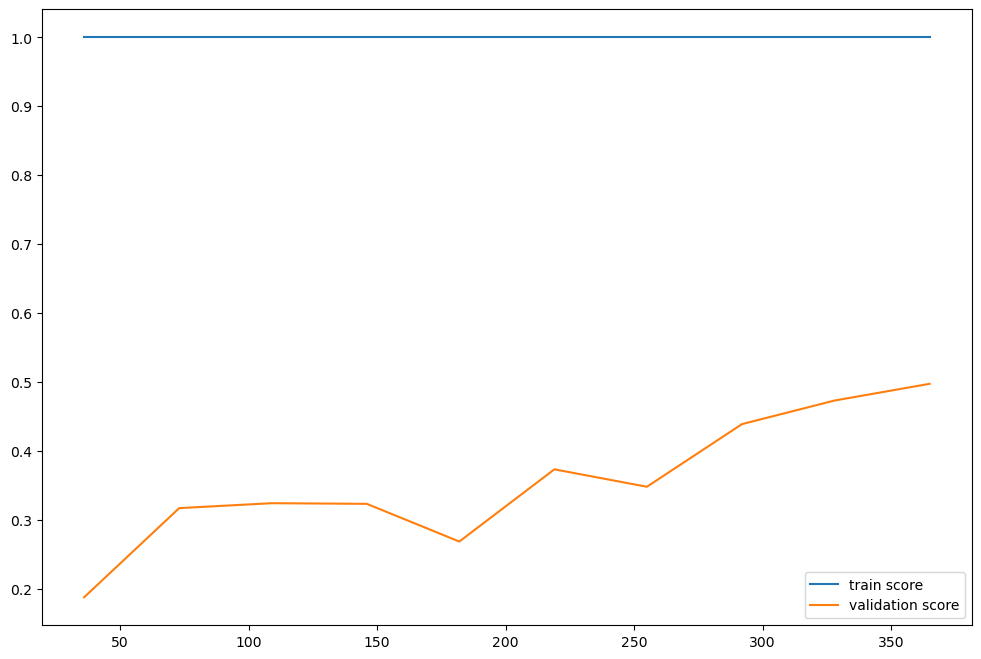

In [54]:
#appliquer la fonction evaluation() sur model_1 pour évaluer le modèle
evaluation(model_1)

<Axes: >

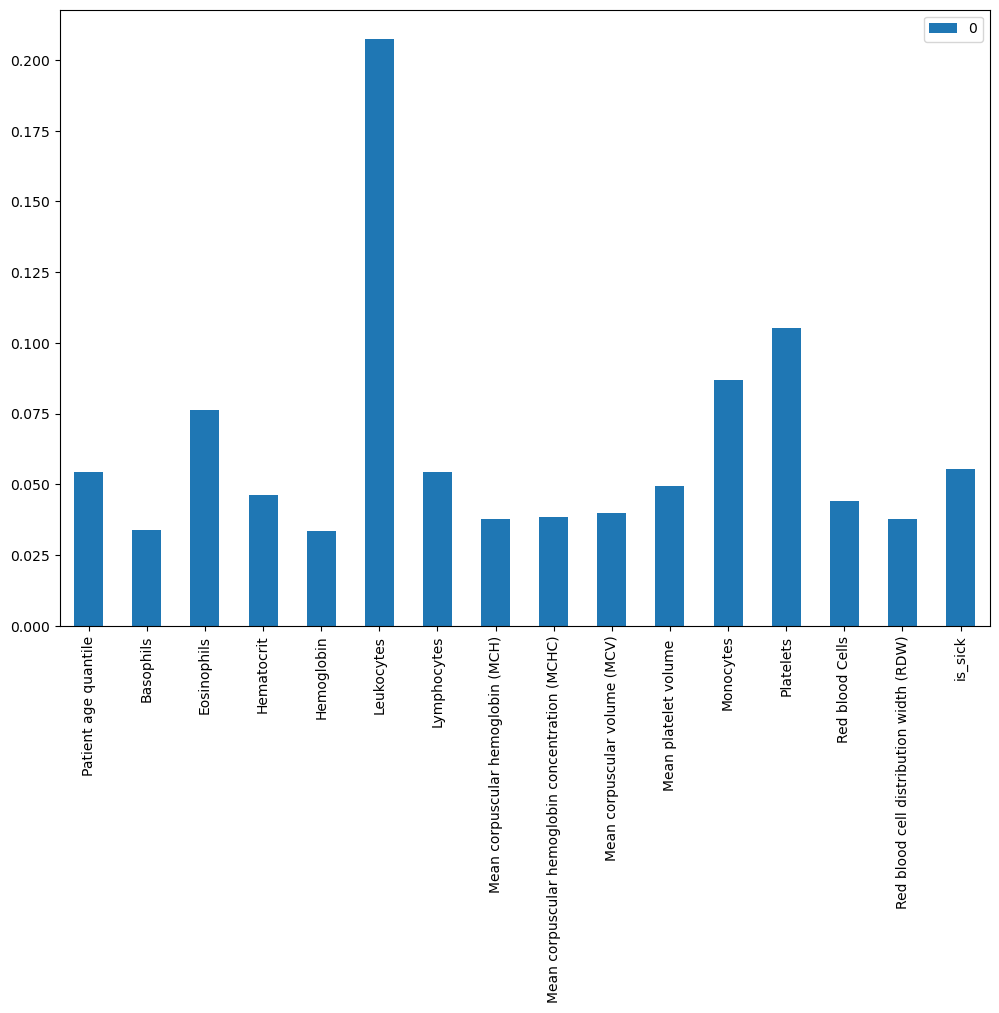

In [55]:
#créer un graphique en barres pour visualiser l'importance des caractéristiques du modèle  
pd.DataFrame(model_1.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))

In [56]:
'''
Explication du code :

- Extraction de l'importance des caractéristiques :

model_1.feature_importances_ : Cette partie du code récupère les importances des caractéristiques calculées par le modèle model_1.
Celles-ci indiquent dans quelle mesure chaque caractéristique a contribué à la prédiction du modèle.
Cette fonctionnalité est généralement disponible pour les modèles d'arbres de décision,
comme les forêts aléatoires ou les modèles de gradient boosting.

- Création d'un DataFrame :

pd.DataFrame(..., index=X_train.columns) : Ici, un DataFrame est créé à partir des importances des caractéristiques.
Les indices du DataFrame sont les noms des caractéristiques, que l'on obtient à partir de X_train.columns.
Cela permet d'associer chaque importance à la caractéristique correspondante.

- Visualisation avec un graphique en barres :

.plot.bar(figsize=(12, 8)) : Cette méthode génère un graphique en barres à partir du DataFrame créé précédemment.
Le paramètre figsize=(12, 8) définit la taille de la figure, où 12 est la largeur et 8 est la hauteur.
Le graphique montre les importances des caractéristiques,
permettant de visualiser facilement quelles caractéristiques sont les plus influentes pour les prédictions du modèle.

-Résumé :

Ce code crée un graphique qui aide à évaluer visuellement quelles caractéristiques ont le plus d'impact sur les prédictions d'un modèle de ML.
Cela peut être très utile pour l'interprétation du modèle et pour identifier les caractéristiques sur lesquelles focaliser les efforts
de feature engineering ou de sélection de caractéristiques.

'''

"\nExplication du code :\n\n- Extraction de l'importance des caractéristiques :\n\nmodel_1.feature_importances_ : Cette partie du code récupère les importances des caractéristiques calculées par le modèle model_1.\nCelles-ci indiquent dans quelle mesure chaque caractéristique a contribué à la prédiction du modèle.\nCette fonctionnalité est généralement disponible pour les modèles d'arbres de décision,\ncomme les forêts aléatoires ou les modèles de gradient boosting.\n\n- Création d'un DataFrame :\n\npd.DataFrame(..., index=X_train.columns) : Ici, un DataFrame est créé à partir des importances des caractéristiques.\nLes indices du DataFrame sont les noms des caractéristiques, que l'on obtient à partir de X_train.columns.\nCela permet d'associer chaque importance à la caractéristique correspondante.\n\n- Visualisation avec un graphique en barres :\n\n.plot.bar(figsize=(12, 8)) : Cette méthode génère un graphique en barres à partir du DataFrame créé précédemment.\nLe paramètre figsize=(12